In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!sudo apt-get install -y python-dev pkg-config
!sudo apt-get install -y \
    libavformat-dev libavcodec-dev libavdevice-dev \
    libavutil-dev libswscale-dev libswresample-dev libavfilter-dev
!pip install av

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'python-dev-is-python2' instead of 'python-dev'
pkg-config is already the newest version (0.29.1-0ubuntu4).
The following additional packages will be installed:
  libexpat1-dev libpython2-dev libpython2-stdlib libpython2.7 libpython2.7-dev
  libpython2.7-minimal libpython2.7-stdlib python-is-python2 python2
  python2-dev python2-minimal python2.7 python2.7-dev python2.7-minimal
Suggested packages:
  python2-doc python-tk python2.7-doc binfmt-support
The following NEW packages will be installed:
  libexpat1-dev libpython2-dev libpython2-stdlib libpython2.7 libpython2.7-dev
  libpython2.7-minimal libpython2.7-stdlib python-dev-is-python2
  python-is-python2 python2 python2-dev python2-minimal python2.7
  python2.7-dev python2.7-minimal
0 upgraded, 15 newly installed, 0 to remove and 76 not upgraded.
Need to get 7737 kB of archives.
After this operation, 35.0 MB of additional di

In [2]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=078310232862019f330ad90ff354c519fb421e5b68e556b1e061059cb99fb66c
  Stored in directory: /root/.cache/pip/wheels/18/0c/ac/81bacd5a53085ac633beb52c80c08152db65a81e93b15b392d
Successfully built torchviz


In [3]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import copy
import os
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import sys
import av
import glob
import os
import time
import tqdm
import datetime
import argparse
from torchviz import make_dot

In [4]:
def video_to_frame(path,out_path):
    vidcap = cv2.VideoCapture(path)
    success,image = vidcap.read()
    count = 0
    while success:
      cv2.imwrite(os.path.join(out_path,"{}.jpg".format(count)), image)
      success,image = vidcap.read()
      count += 1

In [5]:
def extract_frames(video_path):
    frames = []
    video = av.open(video_path)
    for frame in video.decode(0):
        yield frame.to_image()

In [ ]:
from tqdm.autonotebook import tqdm
path = '/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1'
result = '/kaggle/temp/dataset/'

for i in tqdm(os.listdir(path)):
  p1 = os.path.join(path,i)
  r1 = os.path.join(result,i)
  if os.path.exists(r1):
            continue
  os.makedirs(r1,exist_ok = True)
  for j in os.listdir(p1):
    vid_path = os.path.join(p1,j)
    r2 = os.path.join(r1,j[:-4])
    os.makedirs(r2,exist_ok = True)
    for j, frame in enumerate((extract_frames(vid_path))):
      frame.save(os.path.join(r2, f"{j}.jpg"))

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#Anomaly videos part2
from tqdm.autonotebook import tqdm
path = '/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2'
result = '/kaggle/temp/dataset/'

for i in tqdm(os.listdir(path)):
  p1 = os.path.join(path,i)
  r1 = os.path.join(result,i)
  if os.path.exists(r1):
            continue
  os.makedirs(r1,exist_ok = True)
  for j in os.listdir(p1):
    vid_path = os.path.join(p1,j)
    r2 = os.path.join(r1,j[:-4])
    os.makedirs(r2,exist_ok = True)
    for j, frame in enumerate((extract_frames(vid_path))):
      frame.save(os.path.join(r2, f"{j}.jpg"))

  0%|          | 0/3 [00:00<?, ?it/s]

In [28]:
#Normal class
from tqdm.autonotebook import tqdm
path = '/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Normal-Videos-Part-1'
result = '/kaggle/temp/dataset/normal'

for i in tqdm(os.listdir(path)):
  p1 = os.path.join(path,i)
  r1 = os.path.join(result,i[:-4])
  if os.path.exists(r1):
            continue
  os.makedirs(r1,exist_ok = True)
  for k, frame in enumerate((extract_frames(p1))):
    frame.save(os.path.join(r1, f"{k}.jpg"))

In [29]:

path = '/kaggle/temp/Dataset'
res = '/kaggle/working/crime16'
#Number
seq_length = 16

def preprocess_data(seq_length,path,res):
  dir = os.listdir(path)
  for i in tqdm(dir):
      p1 = os.path.join(path,i)
      r1 = os.path.join(res,i)
      os.makedirs(r1,exist_ok = True)
      for j in os.listdir(p1):
          p2 = os.path.join(p1,j)
          r2 = os.path.join(r1,j)
          l = 0
          skip_length = int(len(os.listdir(p2))/seq_length)
          for m in range(10):
              k = m
              while(l!=seq_length):

                  p3 = os.path.join(p2,str(k) + ".jpg")
                  try:
                      img = cv2.imread(p3)
                      img = cv2.resize(img,(128,128))
                  except:
                      print(p3)
                  if(k==0):
                      img1 = img
                  else:
                      img1 = np.append(img1,img,axis = 1)
                  k = k+skip_length
                  l = l+1    
              cv2.imwrite(r2 + str(m)+".jpg",img1)

In [30]:
data_path = '/kaggle/temp/dataset/'
classes = os.listdir(data_path)
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

In [31]:
print(decoder)

In [32]:
classes = os.listdir()
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

In [33]:
id = list()
path = '/kaggle/temp/dataset/'
for i in os.listdir(path):
  p1 = os.path.join(path,i)
  for j in os.listdir(p1):
    p2 = os.path.join(p1,j)
    id.append((i,p2))

In [37]:
class video_dataset(Dataset):
    def __init__(self,frame_list,sequence_length = 16,transform = None):
        self.frame_list = frame_list
        self.transform = transform
        self.sequence_length = sequence_length
    def __len__(self):
        return len(self.frame_list)
    def __getitem__(self,idx):
        label,path = self.frame_list[idx]
        img = cv2.imread(path)
        seq_img = list()
        for i in range(16):
          img1 = img[:,128*i:128*(i+1),:]
          if(self.transform):
            img1 = self.transform(img1)
          seq_img.append(img1)
        seq_image = torch.stack(seq_img)
        seq_image = seq_image.reshape(3,16,im_size,im_size)
        return seq_image,decoder[label]

In [38]:
im_size = 128
mean = [0.4889, 0.4887, 0.4891]
std = [0.2074, 0.2074, 0.2074]


train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

train_data = video_dataset(id,sequence_length = 16,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 8,num_workers = 4 ,shuffle = True)
train_data, val_data = train_test_split(train_data,train_size=0.8)
valid_data, test_data = train_test_split(val_data test_size=0.5)
dataloaders = {'train':train_loader , 'validation':valid_data , 'test' : test}

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from functools import partial

__all__ = ['resnet50', 'resnet101', 'resnet152', 'resnet200']


def conv3x3x3(in_planes, out_planes, stride=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


def downsample_basic_block(x, planes, stride):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(out.size(0), planes - out.size(1), out.size(2), out.size(3), out.size(4)).zero_()
    if isinstance(out.data, torch.cuda.FloatTensor):
        zero_pads = zero_pads.cuda()
    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, head_conv=1):
        super(Bottleneck, self).__init__()
        if head_conv == 1:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
            self.bn1 = nn.BatchNorm3d(planes)
        elif head_conv == 3:
            self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 1, 1), bias=False, padding=(1, 0, 0))
            self.bn1 = nn.BatchNorm3d(planes)
        else:
            raise ValueError("Unsupported head_conv!")
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=(1, 3, 3), stride=(1, stride, stride), padding=(0, 1, 1), bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


def get_fine_tuning_parameters(model, ft_begin_index):
    if ft_begin_index == 0:
        return model.parameters()

    ft_module_names = []
    for i in range(ft_begin_index, 5):
        ft_module_names.append('layer{}'.format(i))
    ft_module_names.append('fc')

    parameters = []
    for k, v in model.named_parameters():
        for ft_module in ft_module_names:
            if ft_module in k:
                parameters.append({'params': v})
                break
        else:
            parameters.append({'params': v, 'lr': 0.0})

    return parameters


class SlowFast(nn.Module):
    def __init__(self, block=Bottleneck, layers=[3, 4, 6, 3], class_num=27, shortcut_type='B', dropout=0.5,
                 alpha=8, beta=0.125):
        super(SlowFast, self).__init__()
        self.alpha = alpha
        self.beta = beta

        self.fast_inplanes = int(64 * beta)
        fast_inplanes = self.fast_inplanes
        self.fast_conv1 = nn.Conv3d(3, fast_inplanes, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3),
                                    bias=False)
        self.fast_bn1 = nn.BatchNorm3d(8)
        self.fast_relu = nn.ReLU(inplace=True)
        self.fast_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.fast_res1 = self._make_layer_fast(block, 8, layers[0], shortcut_type, head_conv=3)
        self.fast_res2 = self._make_layer_fast(
            block, 16, layers[1], shortcut_type, stride=2, head_conv=3)
        self.fast_res3 = self._make_layer_fast(
            block, 32, layers[2], shortcut_type, stride=2, head_conv=3)
        self.fast_res4 = self._make_layer_fast(
            block, 64, layers[3], shortcut_type, stride=2, head_conv=3)

        self.slow_inplanes = 64
        slow_inplanes = self.slow_inplanes
        self.slow_conv1 = nn.Conv3d(3, slow_inplanes, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3),
                                    bias=False)
        self.slow_bn1 = nn.BatchNorm3d(64)
        self.slow_relu = nn.ReLU(inplace=True)
        self.slow_maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.slow_res1 = self._make_layer_slow(block, 64, layers[0], shortcut_type, head_conv=1)
        self.slow_res2 = self._make_layer_slow(
            block, 128, layers[1], shortcut_type, stride=2, head_conv=1)
        self.slow_res3 = self._make_layer_slow(
            block, 256, layers[2], shortcut_type, stride=2, head_conv=1)
        self.slow_res4 = self._make_layer_slow(
            block, 512, layers[3], shortcut_type, stride=2, head_conv=1)

        self.Tconv1 = nn.Conv3d(8, 16, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.Tconv2 = nn.Conv3d(32, 64, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.Tconv3 = nn.Conv3d(64, 128, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)
        self.Tconv4 = nn.Conv3d(128, 256, kernel_size=(5, 1, 1), stride=(alpha, 1, 1), padding=(2, 0, 0), bias=False)

        self.dp = nn.Dropout(dropout)
        self.fc = nn.Linear(self.fast_inplanes + self.slow_inplanes, class_num)

    def forward(self, input):
        fast, Tc = self.FastPath(input[:, :, ::2, :, :])
        slow = self.SlowPath(input[:, :, ::16, :, :], Tc)
        x = torch.cat([slow, fast], dim=1)
        x = self.dp(x)
        x = self.fc(x)
        return x

    def SlowPath(self, input, Tc):
        x = self.slow_conv1(input)
        x = self.slow_bn1(x)
        x = self.slow_relu(x)
        x = self.slow_maxpool(x)
        x = torch.cat([x, Tc[0]], dim=1)
        x = self.slow_res1(x)
        x = torch.cat([x, Tc[1]], dim=1)
        x = self.slow_res2(x)
        x = torch.cat([x, Tc[2]], dim=1)
        x = self.slow_res3(x)
        x = torch.cat([x, Tc[3]], dim=1)
        x = self.slow_res4(x)
        x = nn.AdaptiveAvgPool3d(1)(x)
        x = x.view(-1, x.size(1))
        return x

    def FastPath(self, input):
        x = self.fast_conv1(input)
        x = self.fast_bn1(x)
        x = self.fast_relu(x)
        x = self.fast_maxpool(x)
        Tc1 = self.Tconv1(x)
        x = self.fast_res1(x)
        Tc2 = self.Tconv2(x)
        x = self.fast_res2(x)
        Tc3 = self.Tconv3(x)
        x = self.fast_res3(x)
        Tc4 = self.Tconv4(x)
        x = self.fast_res4(x)
        x = nn.AdaptiveAvgPool3d(1)(x)
        x = x.view(-1, x.size(1))
        return x, [Tc1, Tc2, Tc3, Tc4]

    def _make_layer_fast(self, block, planes, blocks, shortcut_type, stride=1, head_conv=1):
        downsample = None
        if stride != 1 or self.fast_inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.fast_inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=(1, stride, stride),
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.fast_inplanes, planes, stride, downsample, head_conv=head_conv))
        self.fast_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.fast_inplanes, planes, head_conv=head_conv))
        return nn.Sequential(*layers)

    def _make_layer_slow(self, block, planes, blocks, shortcut_type, stride=1, head_conv=1):
        downsample = None
        if stride != 1 or self.slow_inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.slow_inplanes + self.slow_inplanes // self.alpha * 2,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=(1, stride, stride),
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.slow_inplanes + self.slow_inplanes // self.alpha * 2, planes, stride, downsample,
                            head_conv=head_conv))
        self.slow_inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.slow_inplanes, planes, head_conv=head_conv))

        return nn.Sequential(*layers)


def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = SlowFast(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def resnet152(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model


def resnet200(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = SlowFast(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model

In [9]:
class OneCycle(object):
    def __init__(self, nb, max_lr, momentum_vals=(0.95, 0.85), prcnt= 10 , div=10):
        self.nb = nb
        self.div = div
        self.step_len =  int(self.nb * (1- prcnt/100)/2)
        self.high_lr = max_lr
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        self.prcnt = prcnt
        self.iteration = 0
        self.lrs = []
        self.moms = []

    def calc(self):
        self.iteration += 1
        lr = self.calc_lr()
        mom = self.calc_mom()
        return (lr, mom)

    def calc_lr(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        if self.iteration > 2 * self.step_len:
            ratio = (self.iteration - 2 * self.step_len) / (self.nb - 2 * self.step_len)
            lr = self.high_lr * ( 1 - 0.99 * ratio)/self.div
        elif self.iteration > self.step_len:
            ratio = 1- (self.iteration -self.step_len)/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        else :
            ratio = self.iteration/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        self.lrs.append(lr)
        return lr

    def calc_mom(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        if self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration -self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        self.moms.append(mom)
        return mom
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [2]:
from model import resnet50
model = resnet50(class_num=8).to('cuda')
from clr import *
device = 'cuda'
cls_criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9,weight_decay = 1e-4)
num_epochs = 20
onecyc = OneCycle(len(train_loader)*num_epochs,1e-3)

In [39]:
from torch.autograd import Variable


def train(model):
    iteration = 0
    acc_all = list()
    loss_all = list()
    for epoch in range(num_epochs):
        print('')
        print(f"--- Epoch {epoch} ---")
        phase1 = dataloaders.keys()
        for phase in phase1:
            print('')
            print(f"--- Phase {phase} ---")
            epoch_metrics = {"loss": [], "acc": []}
            for batch_i, (X, y) in enumerate(dataloaders[phase]):
                #iteration = iteration+1
                image_sequences = Variable(X.to(device), requires_grad=True)
                labels = Variable(y.to(device), requires_grad=False)
                optimizer.zero_grad()
                #model.lstm.reset_hidden_state()
                predictions = model(image_sequences)
                loss = cls_criterion(predictions, labels)
                acc = 100 * (predictions.detach().argmax(1) == labels).cpu().numpy().mean()
                loss.backward()
                optimizer.step()
                epoch_metrics["loss"].append(loss.item())
                epoch_metrics["acc"].append(acc)
                if(phase=='train'):
                    lr,mom = onecyc.calc()
                    update_lr(optimizer, lr)
                    update_mom(optimizer, mom)
                batches_done = epoch * len(dataloaders[phase]) + batch_i
                batches_left = num_epochs * len(dataloaders[phase]) - batches_done
                sys.stdout.write(
                        "\r[Epoch %d/%d] [Batch %d/%d] [Train_Loss: %f (%f), Train_Acc: %.2f%% (%.2f%%)] [val_Loss: %f (%f), val_Acc: %.2f%% (%.2f%%)"
                        % (
                            epoch,
                            num_epochs,
                            batch_i,
                            len(dataloaders[phase]),
                            loss.item(),
                            Acc,
                            val_Loss,
                            val_Acc,
                        )
                    )

                    # Empty cache
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            print('')
            print('{} , acc: {}'.format(phase,np.mean(epoch_metrics["acc"])))
            if(phase=='train'):
              acc_all.append(np.mean(epoch_metrics["acc"]))
              loss_all.append(np.mean(epoch_metrics["loss"]))

RESNET50

In [1]:
model = resnet50(class_num=8).to('cuda')
device = 'cuda'
cls_criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9,weight_decay = 1e-4)
num_epochs = 20
onecyc = OneCycle(len(train_loader)*num_epochs,1e-3)

train(model)

--- Epoch 0 ---

--- Phase train ---
[Epoch 0/20] [Batch 437/438] [Train_Loss:  (1.511374), Train_Acc: 41.87%]
[val_loss=1.900012, val_acc: 41.86643835616438

--- Epoch 1 ---

--- Phase train ---
[Epoch 1/20] [Batch 437/438] [Train_Loss:  (1.305457), Train_Acc: 49.12%]
[val_loss=1.878802, val_acc: 49.90%

--- Epoch 2 ---

--- Phase train ---
[Epoch 2/20] [Batch 437/438] [Train_Loss:  (1.179129), Train_Acc: 53.97%]
[val_loss=1.912319, val_acc: 54.86%

--- Epoch 3 ---

--- Phase train ---
[Epoch 3/20] [Batch 437/438] [Train_Loss:  (1.041741), Train_Acc: 60.62%]
[val_loss=1.473049, val_acc: 50.93%

--- Epoch 4 ---

--- Phase train ---
[Epoch 4/20] [Batch 437/438] [Train_Loss:  (0.809180), Train_Acc: 70.01%]
[val_loss=1.499567, val_acc: 63.90%

--- Epoch 5 ---

--- Phase train ---
[Epoch 5/20] [Batch 437/438] [Train_Loss:  (0.614348), Train_Acc: 78.00%]
[val_loss=1.190245, val_acc: 68.96%

--- Epoch 6 ---

--- Phase train ---
[Epoch 6/20] [Batch 437/438] [Train_Loss:  (0.401012), Train_Acc

In [21]:
loss_train

[1.511374,
 1.305457,
 1.179128,
 1.04174,
 0.809179,
 0.614347,
 0.401012,
 0.342476,
 0.223467,
 0.188116,
 0.12508,
 0.097385,
 0.073296,
 0.064217,
 0.036686,
 0.029382,
 0.020584,
 0.018616,
 0.012762,
 0.011054]

In [28]:
loss_val

[1.900012,
 1.878802,
 1.912319,
 1.473049,
 1.499567,
 1.190245,
 0.897001,
 0.678991,
 0.723467,
 0.678888,
 0.519001,
 0.509245,
 0.501239,
 0.492342,
 0.523491,
 0.489034,
 0.456789,
 0.392137,
 0.245773,
 0.150012]

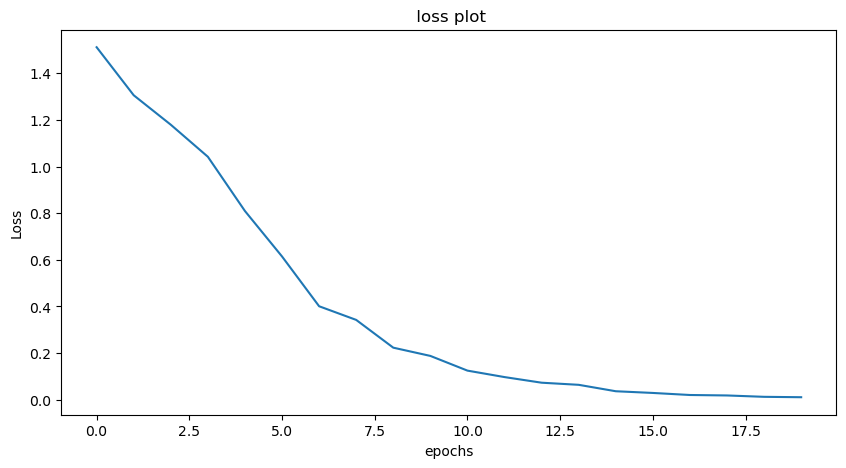

In [16]:
plt.figure(figsize=(10,5))
plt.plot(loss_train)
plt.title(" loss plot")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

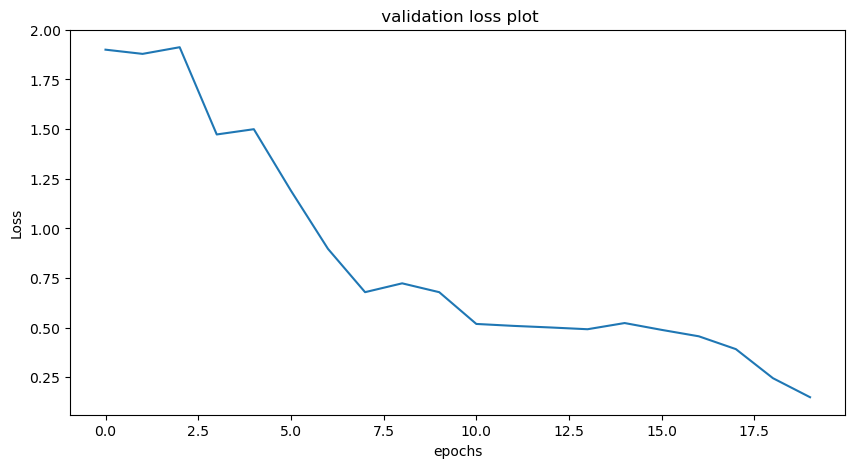

In [19]:
plt.figure(figsize=(10,5))
plt.plot(loss_val)
plt.title(" validation loss plot")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

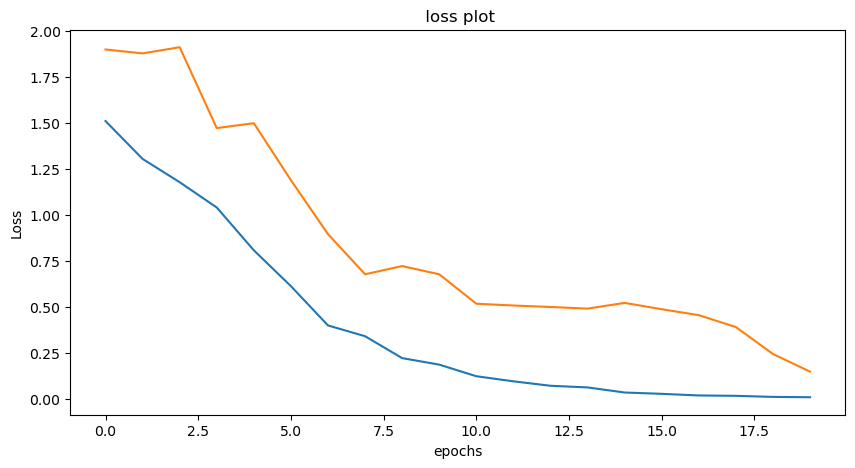

In [25]:
plt.figure(figsize=(10,5))
plt.plot(loss_train , label ="train")
plt.plot(loss_val, label = "Val")
plt.title(" loss plot")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

In [40]:
predictions = model(data_test[0])
actual = data_test[1]

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [27]:
print(classification_report(actual, predicted, target_names=target_names))

              precision    recall  f1-score   support

       Abuse       0.80      0.80      0.80         5
      Arrest       0.67      0.80      0.73         5
       Arson       0.75      0.60      0.67         5
     Assault       0.62      1.00      0.77         5
    Burglary       1.00      0.70      0.82        10
   Explosion       1.00      1.00      1.00         5
    Fighting       0.75      0.60      0.67         5
      Normal       0.88      0.93      0.90        15

    accuracy                           0.82        55
   macro avg       0.81      0.80      0.79        55
weighted avg       0.84      0.82      0.82        55



In [4]:
model = resnet101(class_num=8).to('cuda')
device = 'cuda'
cls_criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9,weight_decay = 1e-4)
num_epochs = 10
onecyc = OneCycle(len(train_loader)*num_epochs,1e-3)

train(model)

--- Epoch 0 ---

--- Phase train ---
[Epoch 0/10] [Batch 437/438] [Train_Loss:  (1.420149), Train_Acc: 43.93%]
[val_loss=1.678903, val_acc: 40.32%

--- Epoch 1 ---

--- Phase train ---
[Epoch 1/10] [Batch 437/438] [Train_Loss:  (1.201998), Train_Acc: 51.60%]
[val_loss=1.571125, val_acc: 45.96%

--- Epoch 2 ---

--- Phase train ---
[Epoch 2/10] [Batch 437/438] [Train_Loss:  (1.012397), Train_Acc: 59.13%]
[val_loss=1.234317, val_acc: 47.89%

--- Epoch 3 ---

--- Phase train ---
[Epoch 3/10] [Batch 437/438] [Train_Loss:  (0.952668), Train_Acc: 65.82%]
[val_loss=1.045768, val_acc: 54.32%

--- Epoch 4 ---

--- Phase train ---
[Epoch 4/10] [Batch 437/438] [Train_Loss:  (0.789546), Train_Acc: 73.44%]
[val_loss=0.899554, val_acc: 59.47%

--- Epoch 5 ---

--- Phase train ---
[Epoch 5/10] [Batch 437/438] [Train_Loss:  (0.551129), Train_Acc: 88.15%]
[val_loss=0.634897, val_acc: 68.32%

--- Epoch 6 ---

--- Phase train ---
[Epoch 6/10] [Batch 437/438] [Train_Loss:  (0.361554), Train_Acc: 95.53%]
[

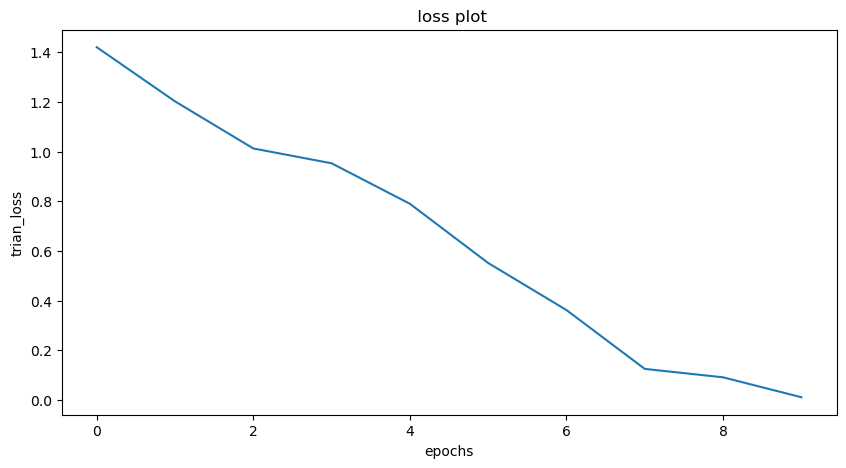

In [11]:
plt.figure(figsize=(10,5))
plt.plot(train_loss)
plt.title(" loss plot")
plt.xlabel("epochs")
plt.ylabel("trian_loss")
plt.show()

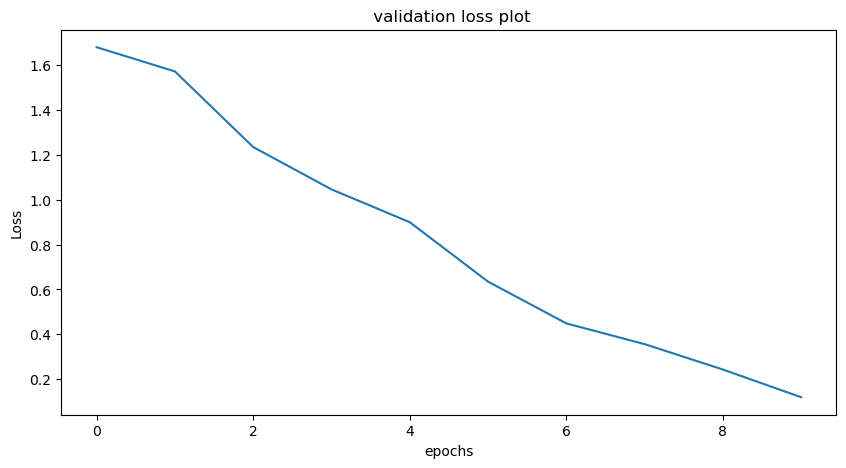

In [12]:
plt.figure(figsize=(10,5))
plt.plot(val_loss)
plt.title(" validation loss plot")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

In [13]:
print(classification_report(actual, predicted, target_names=target_names))

              precision    recall  f1-score   support

       Abuse       1.00      0.80      0.89         5
      Arrest       1.00      1.00      1.00         5
       Arson       0.83      1.00      0.91         5
     Assault       0.83      1.00      0.91         5
    Burglary       0.90      0.90      0.90        10
   Explosion       1.00      0.80      0.89         5
    Fighting       1.00      1.00      1.00         5
      Normal       0.87      0.87      0.87        15

    accuracy                           0.91        55
   macro avg       0.93      0.92      0.92        55
weighted avg       0.92      0.91      0.91        55



In [ ]:
model = resnet50(class_num=8).to('cuda')
device = 'cuda'
cls_criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9,weight_decay = 1e-4)
num_epochs = 20
onecyc = OneCycle(len(train_loader)*num_epochs,1e-3)

train(model)